In [1]:
import numpy as np
import pandas as pd

In [2]:
df=pd.read_csv('perrin-freres-monthly-champagne-.csv')

In [3]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [4]:
df.isnull().sum()

Month                                                     1
Perrin Freres monthly champagne sales millions ?64-?72    2
dtype: int64

In [5]:
#dropping the null values since there are so few
df.dropna(inplace=True)

In [6]:
df.columns=['Month','Sales']

In [8]:
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [9]:
df.dtypes

Month     object
Sales    float64
dtype: object

In [12]:
df['Month']=pd.to_datetime(df['Month'])

In [13]:
df.dtypes

Month    datetime64[ns]
Sales           float64
dtype: object

In [14]:
#Setting index as the month for time series analysis
df.set_index('Month',inplace=True)

In [15]:
#Checking stats of data
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


<AxesSubplot:xlabel='Month'>

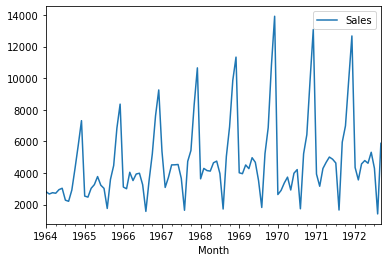

In [16]:
# Visualizing the sales column
df.plot()

In [17]:
#From the graph it is clear that there is seasonality present

In [18]:
#adfuller test, p-value < 0.05
#Null Hypothesis - data is not stationary
#h1 - data is stationary
from statsmodels.tsa.stattools import adfuller
adfuller(df['Sales'])

(-1.8335930563276222,
 0.3639157716602455,
 11,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 1478.4633060594724)

In [19]:
def adfuller_test(sales):
    result=adfuller(sales)
    
    labels=['ADF test statistics','p-value','Lags_Used','Number of obs used']
    for value,label in zip(result,labels):
        print('{} : {}'.format(label,value))
    if result[1] < 0.05:
        print('Strong evidence against null hypothesis, so reject null')
    else:
        print('Weak evidence against null hypothesis, so accept null')

In [20]:
adfuller_test(df['Sales'])

ADF test statistics : -1.8335930563276222
p-value : 0.3639157716602455
Lags_Used : 11
Number of obs used : 93
Weak evidence against null hypothesis, so accept null


In [21]:
# We need to make data stationary
df['Sales'].shift(1)


Month
1964-01-01       NaN
1964-02-01    2815.0
1964-03-01    2672.0
1964-04-01    2755.0
1964-05-01    2721.0
               ...  
1972-05-01    4788.0
1972-06-01    4618.0
1972-07-01    5312.0
1972-08-01    4298.0
1972-09-01    1413.0
Name: Sales, Length: 105, dtype: float64

In [23]:
df['Sales_First_diff']=df['Sales'] - df['Sales'].shift(1)

In [24]:
df.head()

,Sales,Sales_First_diff
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,-143.0
1964-03-01,2755.0,83.0
1964-04-01,2721.0,-34.0
1964-05-01,2946.0,225.0


In [25]:
#Shifting by 12 because doing it for the entire year
df['Seasonal_First_diff']=df['Sales'] - df['Sales'].shift(12)

In [26]:
df.head()

,Sales,Sales_First_diff,Seasonal_First_diff
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN


In [27]:
adfuller_test(df['Seasonal_First_diff'].dropna())

ADF test statistics : -7.626619157213162
p-value : 2.060579696813685e-11
Lags_Used : 0
Number of obs used : 92
Strong evidence against null hypothesis, so reject null


<AxesSubplot:xlabel='Month'>

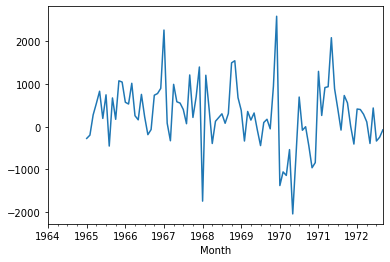

In [28]:
df['Seasonal_First_diff'].plot()

In [29]:
#Almost close to a stationary trend

In [30]:
#Arima-- AR + I + MA
# (p,d,q)
# p - pacf graph
# d=1
# q - acf graph

In [31]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

In [32]:
import matplotlib.pyplot as plt

C:\Users\Prabhu\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


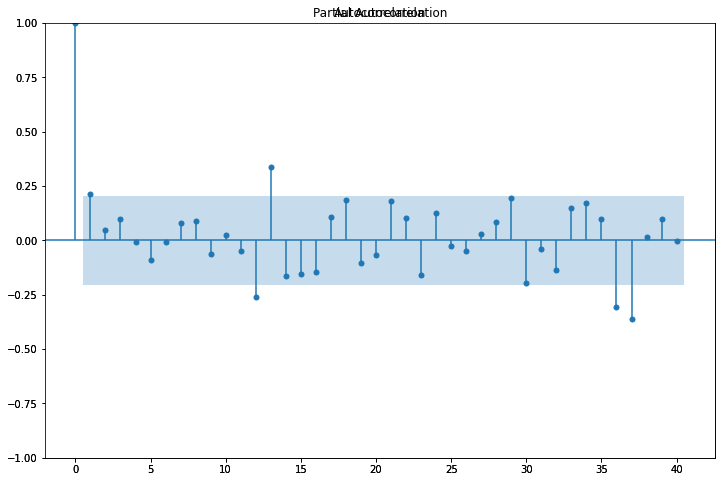

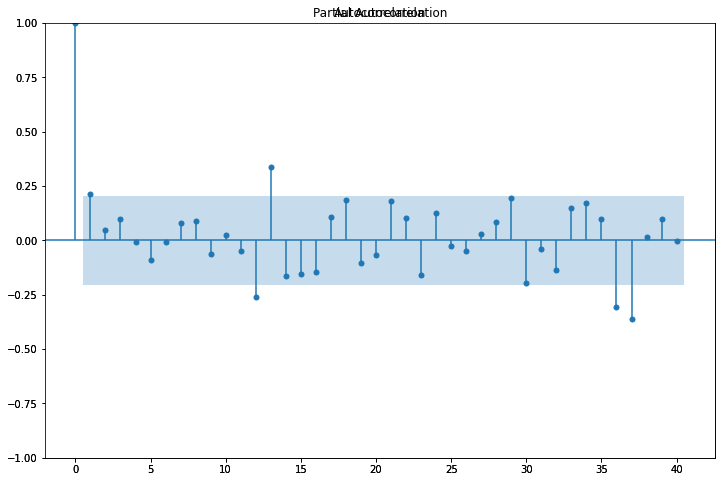

In [34]:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot()
plot_acf(df['Seasonal_First_diff'].iloc[13:],lags=40,ax=ax1)

ax2=fig.add_subplot()
plot_pacf(df['Seasonal_First_diff'].iloc[13:],lags=40,ax=ax2)

In [35]:
## p,d,q

In [39]:
from statsmodels.tsa.arima.model import ARIMA

In [40]:
model=ARIMA(df['Sales'],order=(1,1,1))

C:\Users\Prabhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [41]:
model = model.fit()

In [42]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                Tue, 11 Apr 2023   AIC                           1911.627
Time:                        18:32:42   BIC                           1919.560
Sample:                    01-01-1964   HQIC                          1914.841
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      3.999      0.000       0.232       0.677
ma.L1         -0.9666      0.056    -17.316      0.000      -1.076      -0.857
sigma2      5.226e+06   6.17e+05      8.473      0.000    4.02e+06    6.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.34   Prob(JB):                         0.27
Heteroskedasticity (H):               3.40   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
df['forecast']=model.predict(start=90,end=103,dynamic=True)

In [44]:
df.head()

,Sales,Sales_First_diff,Seasonal_First_diff,forecast
Month,,,,
1964-01-01,2815.0,NaN,NaN,NaN
1964-02-01,2672.0,-143.0,NaN,NaN
1964-03-01,2755.0,83.0,NaN,NaN
1964-04-01,2721.0,-34.0,NaN,NaN
1964-05-01,2946.0,225.0,NaN,NaN


In [45]:
df.tail()

,Sales,Sales_First_diff,Seasonal_First_diff,forecast
Month,,,,
1972-05-01,4618.0,-170.0,-392.0,5062.891084
1972-06-01,5312.0,694.0,438.0,5062.908698
1972-07-01,4298.0,-1014.0,-335.0,5062.916704
1972-08-01,1413.0,-2885.0,-246.0,5062.920342
1972-09-01,5877.0,4464.0,-74.0,NaN


<AxesSubplot:xlabel='Month'>

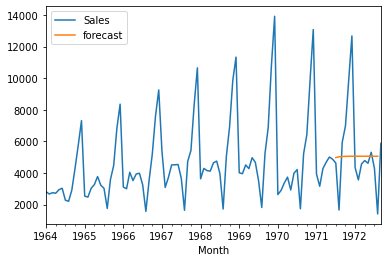

In [46]:
df[['Sales','forecast']].plot()
# As we can see arima doesnt do a good job on seasonal data hence we will use SARIMAX

In [47]:
import statsmodels.api as sm

In [49]:
# order = (p,d,q,season_shift)
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1,1,1),seasonal_order=(1,1,1,12))

C:\Users\Prabhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [50]:
result=model.fit()

In [51]:
df['forecast_sarimax']=result.predict(start=90,end=103,dynamic=True)

In [53]:
df.tail()

,Sales,Sales_First_diff,Seasonal_First_diff,forecast,forecast_sarimax
Month,,,,,
1972-05-01,4618.0,-170.0,-392.0,5062.891084,4717.511708
1972-06-01,5312.0,694.0,438.0,5062.908698,4906.404441
1972-07-01,4298.0,-1014.0,-335.0,5062.916704,4685.437225
1972-08-01,1413.0,-2885.0,-246.0,5062.920342,2232.408881
1972-09-01,5877.0,4464.0,-74.0,NaN,NaN


<AxesSubplot:xlabel='Month'>

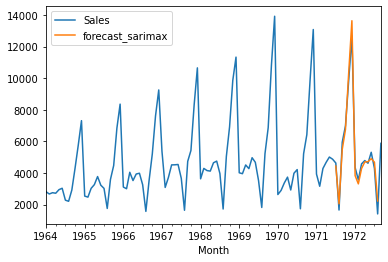

In [55]:
df[['Sales','forecast_sarimax']].plot()

In [56]:
# So we can see the last 12 months for year 72 are predicted correctly

In [59]:
# Predicting future Data
from pandas.tseries.offsets import DateOffset
df.index[-1] # the last month in the dataset

Timestamp('1972-09-01 00:00:00')

In [60]:
#creating future months
future_dates=[df.index[-1] + DateOffset(months=x) for x in range(0,24)]

In [62]:
future_dataset=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [63]:
future_dataset.tail()

,Sales,Sales_First_diff,Seasonal_First_diff,forecast,forecast_sarimax
1974-04-01,NaN,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN,NaN


In [67]:
future_df=pd.concat([df,future_dataset])

In [68]:
future_df['forecast_sarimax_future']=result.predict(start=104,end=124,dynamic=True)

In [69]:
future_df.tail()

,Sales,Sales_First_diff,Seasonal_First_diff,forecast,forecast_sarimax,forecast_sarimax_future
1974-04-01,NaN,NaN,NaN,NaN,NaN,5189.453065
1974-05-01,NaN,NaN,NaN,NaN,NaN,5119.495268
1974-06-01,NaN,NaN,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

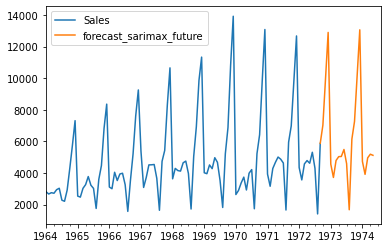

In [71]:
future_df[['Sales','forecast_sarimax_future']].plot()

In [ ]:
# So we are predicting the values in the future months